In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
import re
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from string import punctuation
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors

In [2]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)

True

Kolekcija podataka koja se nalazi u datoteci "News_Category_Dataset_v2.json" sadrži podatke o novinskim člancima koji su sakupljeni tokom perioda od 2012 do 2018 sa sajta www.huffpost.com. Podaci koji će biti korišćeni mogu se naći na sledećem linku: https://www.kaggle.com/rmisra/news-category-dataset.

In [3]:
data = pd.read_json("data/News_Category_Dataset_v2.json", lines = True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [5]:
data.head(10)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26
6,ENTERTAINMENT,Donald Trump Is Lovin' New McDonald's Jingle I...,Ron Dicker,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right.",2018-05-26
7,ENTERTAINMENT,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,2018-05-26
8,ENTERTAINMENT,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,Andy McDonald,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",2018-05-26
9,ENTERTAINMENT,What To Watch On Hulu That’s New This Week,Todd Van Luling,https://www.huffingtonpost.com/entry/hulu-what...,You're getting a recent Academy Award-winning ...,2018-05-26


In [6]:
print("Broj razlicitih autora : ", data["authors"].nunique())

Broj razlicitih autora :  27993


In [7]:
categories = data.groupby('category')
print("UKUPAN BROJ RAZLIČITIH KATEGORIJA: ", categories.ngroups)
print(categories.size())

UKUPAN BROJ RAZLIČITIH KATEGORIJA:  41
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS      

Neke kategorije sadrže isti tip vesti a kategorija nosi sličan naziv, pa čemo izvršiti spajanje:

In [8]:
data.category = data.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
data.category = data.category.map(lambda x: "WORLD NEWS" if x == "WORLDPOST" else x)
data.category = data.category.map(lambda x: "STYLE AND BEAUTY" if x == "STYLE" else x)
data.category = data.category.map(lambda x: "STYLE AND BEAUTY" if x == "STYLE & BEAUTY" else x)
data.category = data.category.map(lambda x: "PARENT" if x == "PARENTING" else x)
data.category = data.category.map(lambda x: "ARTS & CULTURE" if x == "ARTS" else x)
data.category = data.category.map(lambda x: "ARTS & CULTURE" if x == "CULTURE & ARTS" else x)

In [9]:
categories_after_grouping = data.groupby('category')
print("UKUPAN BROJ RAZLIČITIH KATEGORIJA NAKON SPAJANJA: ", categories_after_grouping.ngroups)
print(categories_after_grouping.size())

UKUPAN BROJ RAZLIČITIH KATEGORIJA NAKON SPAJANJA:  36
category
ARTS & CULTURE       3878
BLACK VOICES         4528
BUSINESS             5937
COLLEGE              1144
COMEDY               5175
CRIME                3405
DIVORCE              3426
EDUCATION            1004
ENTERTAINMENT       16058
ENVIRONMENT          1323
FIFTY                1401
FOOD & DRINK         6226
GOOD NEWS            1398
GREEN                2622
HEALTHY LIVING       6694
HOME & LIVING        4195
IMPACT               3459
LATINO VOICES        1129
MEDIA                2815
MONEY                1707
PARENT               8677
PARENTS              3955
POLITICS            32739
QUEER VOICES         6314
RELIGION             2556
SCIENCE              2178
SPORTS               4884
STYLE AND BEAUTY    11903
TASTE                2096
TECH                 2082
TRAVEL               9887
WEDDINGS             3651
WEIRD NEWS           2670
WELLNESS            17827
WOMEN                3490
WORLD NEWS           8420
d

Izvšićemo brisanje članaka koji su duplirani:

In [10]:
print("Broj clanaka pre brisanja: ", data.shape[0])
data.sort_values('headline', inplace=True, ascending=False)
duplicates = data.duplicated('headline', keep = False)
data = data[~duplicates]
print("Broj clanaka nakon brisanja: ", data.shape[0])

Broj clanaka pre brisanja:  200853
Broj clanaka nakon brisanja:  198627


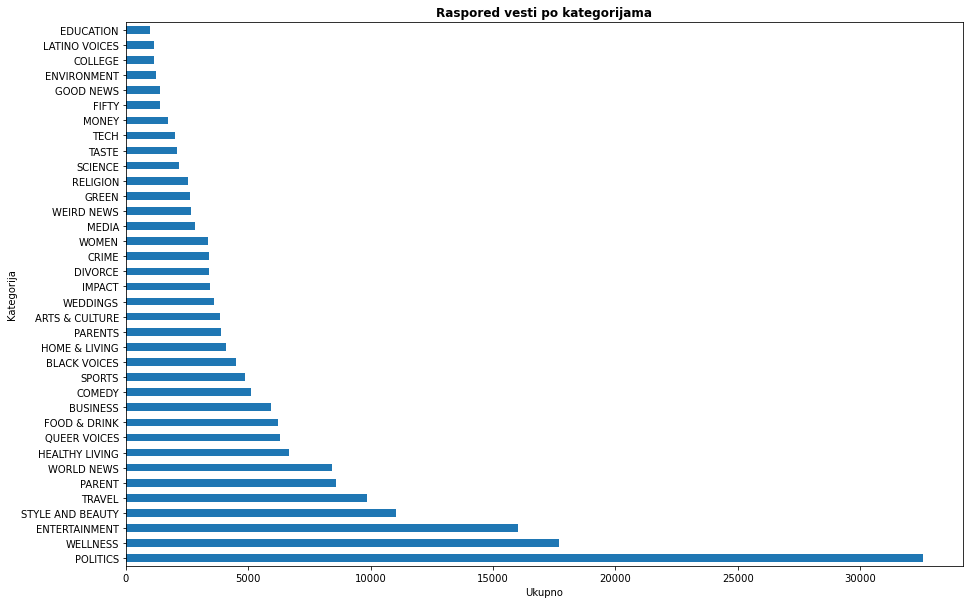

In [11]:
data['category'].value_counts().plot(kind='barh', figsize=(15,10))
plt.xlabel("Ukupno")
plt.ylabel("Kategorija")
plt.title("Raspored vesti po kategorijama", fontweight="bold", size=12);
plt.show()

Podelićemo podatke na X i y skupove, gde će y sadžati kolonu <i>category</i> i X sve ostale kolone koje ćemo obraditi:

In [12]:
y = data['category']
y.head(10)

36290              WOMEN
21194     HEALTHY LIVING
29672           BUSINESS
199048           DIVORCE
193783           DIVORCE
112446             WOMEN
123546        WEIRD NEWS
2932        QUEER VOICES
67601         WEIRD NEWS
85380       BLACK VOICES
Name: category, dtype: object

In [13]:
X = data.drop(columns = ['category'], axis = 1)
X.head()

,headline,authors,link,short_description,date
36290,"“We Shall Overcomb!” Say The 100,000 Marching ...","Darin Graham, ContributorJournalist",https://www.huffingtonpost.com/entry/we-shall-...,Thousands of activists descended on London to ...,2017-01-25
21194,“To The Bone” Didn’t Teach Me Glamour. It Taug...,"Mycah Hazel, Contributorblogger, equal opportu...",https://www.huffingtonpost.com/entry/to-the-bo...,"Oftentimes, films or TV shows about eating dis...",2017-07-18
29672,"“I’m Sorry""--The Two Tragically Forgotten Word...","Dana Brownlee, ContributorPresident of Profess...",https://www.huffingtonpost.com/entry/im-sorryt...,"Unfortunately, I was one of those frustrated p...",2017-04-10
199048,‘Your Divorce Ruined My Life' What To Do When ...,,https://www.huffingtonpost.comhttp://www.thegl...,It was Sunday night and Lucas’s mother had had...,2012-02-16
193783,"‘You Better Sit Down,' By The Civilians, At Fl...",,https://www.huffingtonpost.comhttp://theater.n...,"The Civilians, the enterprising troupe special...",2012-04-13


In [14]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [15]:
STOPWORDS = set(stopwords.words('english'))
punctuation = list(punctuation)
STOPWORDS.update(punctuation)

lemmatizer = WordNetLemmatizer()

def preprocessing_text(text):
    text = text.lower()
    text = re.compile('[/(){}\[\]\|@,;]').sub('', text) 
    text = re.compile('[^a-z #+_]').sub('', text)
    
    clean_text = []
    for w in word_tokenize(text):
        if w.lower() not in STOPWORDS:
            pos = pos_tag([w])
            new_w = lemmatizer.lemmatize(w, pos = get_simple_pos(pos[0][1]))
            clean_text.append(new_w)
    text = " ".join(clean_text)
    
    return text

Izvršićemo čišćenje teksta pomoću funkcije <i>preprocessing_text</i> i to nad kolonama <i>headline</i>, <i>authors</i> i <i>short_description</i> za slučaj da je vrednost jedna od kolona prazna pa kako ne bismo dobili prazan red u X skupu. Ovom funkcijom ćemo ukloniti stop reči iz engleskog jezika(znakovi interpunkcije, česte reči kao što su a, an, the, I i slično) i brojeve. Takođe, očišćen tekst ćemo sačuvati u novoj koloni <i>text</i> skupa X.

In [16]:
X['text'] = X['headline'] + " " + X['short_description'] + " " + X['authors']

In [ ]:
X['text'] = X['text'].apply(preprocessing_text)

In [ ]:
X.head()

Kada smo prečistili tekst obrisaćemo kolone koje smo spojili prethodno i kolone <i>link</i> i <i>date</i> koje nam neće biti potrebne:

In [ ]:
X = X.drop(columns = ['headline', 'authors', 'short_description', 'link', 'date'])

In [ ]:
X.head()

Novodobijene podatke ćemo dodati u prvobitni skup <i>data</i> u kolonu <i>text</i>, a kolone koje nam nisu potrebne ćemo obrisati:

In [ ]:
data = data.drop(columns = ['headline', 'authors', 'short_description', 'link', 'date'])

In [ ]:
data['text'] = X['text']

In [ ]:
data.head()

Očišćene podatke ćemo sačuvati u datoteci <i>vesti.csv</i> kako bismo olakšali učitvanje podataka u kasnijem radu.

In [ ]:
data.to_csv('data/vesti.csv', columns=['text', 'category'])